In [1]:
from model import classic_lda, lda_vae
from sklearn.model_selection import train_test_split
from scipy.io import mmread
import pandas as pd
import time 
import plotnine as pn 

/data/vss2134/miniconda/envs/sctopic/lib/python3.10/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
data = mmread("data/mackosko_scrnaseq_preprocessed.mtx").toarray()
rownames = pd.read_csv("data/mackosko_scrnaseq_preprocessed.mtx.rownames")
colnames = pd.read_csv("data/mackosko_scrnaseq_preprocessed.mtx.colnames")


In [3]:
train_mat, test_mat = train_test_split(data, test_size = .25)
vocab_size = 5000
ntopics = 500
n_epochs = 15

In [16]:
vae_start = time.time()
vae_topic_props, vae_train_loss, vae_test_loss = lda_vae.train_vae_lda(train_mat, test_mat, vocab_size,ntopics, n_epochs )
vae_end = time.time()
vae_coherence = lda_vae.UCI_coherence(vae_topic_props, test_mat, 25)


  0%|          | 0/15 [00:00<?, ?it/s]


KeyboardInterrupt: 

In [5]:
cl_start = time.time()
cl_topic_props,cl_test_loss = classic_lda.train_classic_lda(train_mat, test_mat, vocab_size,ntopics, n_epochs )
cl_end = time.time()
cl_coherence = lda_vae.UCI_coherence(cl_topic_props, test_mat, 25)

calculating scores


100%|██████████| 500/500 [01:48<00:00,  4.62it/s]


In [17]:
vae_loss_df = pd.DataFrame().assign(epoch = list(range(15))[1:], loss = vae_test_loss[1:] )
p2 = (
    pn.ggplot(vae_loss_df) + 
    pn.geom_line(pn.aes(x='epoch', y="loss")) + 
    pn.ggtitle("Loss(ELBO) on heldout data, VAE-LDA") + 
    pn.theme_minimal()
)
p2.save(dpi=100, filename = "vae_lda_loss.png",transparent=False, facecolor='white' )

/data/vss2134/miniconda/envs/sctopic/lib/python3.10/site-packages/plotnine/ggplot.py:718: PlotnineWarning: Saving 6.4 x 4.8 in image.
/data/vss2134/miniconda/envs/sctopic/lib/python3.10/site-packages/plotnine/ggplot.py:719: PlotnineWarning: Filename: vae_lda_loss.png


In [18]:
cl_loss_df = pd.DataFrame().assign(epoch = list(range(len(cl_test_loss[1:]))), loss = cl_test_loss[1:] )
p1 = (
    pn.ggplot(cl_loss_df) + 
    pn.geom_line(pn.aes(x='epoch', y="loss")) + 
    pn.ggtitle("Loss(perplexity) on heldout data, classic-LDA") + 
    pn.theme_minimal()
)
p1.save(dpi=100, filename = "classic_lda_loss.png",transparent=False, facecolor='white')

/data/vss2134/miniconda/envs/sctopic/lib/python3.10/site-packages/plotnine/ggplot.py:718: PlotnineWarning: Saving 6.4 x 4.8 in image.
/data/vss2134/miniconda/envs/sctopic/lib/python3.10/site-packages/plotnine/ggplot.py:719: PlotnineWarning: Filename: classic_lda_loss.png


In [19]:
topic_coherence_df = pd.DataFrame().assign(vae_lda = vae_coherence, classic_lda = cl_coherence).melt(var_name="algorithm", value_name= "UCI coherence")
p3 = (
    pn.ggplot(topic_coherence_df, pn.aes(x= "algorithm", y="UCI coherence")) + 
    pn.geom_violin() +
    pn.geom_boxplot(width = .1)+
    pn.ggtitle("UCI coherence on calculated topics using top 25 word per topic")+
    pn.theme_minimal()
)
p3.save(dpi=100, filename = "uci_coherence.png",transparent=False, facecolor='white')

/data/vss2134/miniconda/envs/sctopic/lib/python3.10/site-packages/plotnine/ggplot.py:718: PlotnineWarning: Saving 6.4 x 4.8 in image.
/data/vss2134/miniconda/envs/sctopic/lib/python3.10/site-packages/plotnine/ggplot.py:719: PlotnineWarning: Filename: uci_coherence.png


In [20]:
topic_coherence_df.groupby("algorithm")['UCI coherence'].mean()

algorithm
classic_lda   -1.623975
vae_lda       -1.684038
Name: UCI coherence, dtype: float64

In [19]:
import pandas as pd 
import numpy as np 
import pickle 
import plotnine as pn 

In [23]:
def read_scores(file):
    with open(file, 'rb') as infl:
        reactome_scores = pickle.load(infl)
        return pd.DataFrame().assign(UCI = reactome_scores)
    

In [13]:
all_react_scores = pd.concat([
    read_scores("/data/vss2134/scTopic/results/vae_lda_normal_5k_50t_reactome_scores.pickle").assign(n_topic = "50"),
    read_scores("/data/vss2134/scTopic/results/vae_lda_normal_5k_500t_reactome_scores.pickle").assign(n_topic = "500"),
    read_scores("/data/vss2134/scTopic/results/vae_lda_normal_5k_100t_reactome_scores.pickle").assign(n_topic = "100"),
    read_scores("/data/vss2134/scTopic/results/vae_lda_normal_5k_reactome_scores.pickle").assign(n_topic = "250")
]).assign(
    n_topic = lambda x: pd.Categorical(x['n_topic'], categories=["50", "100", "250","500"])
)

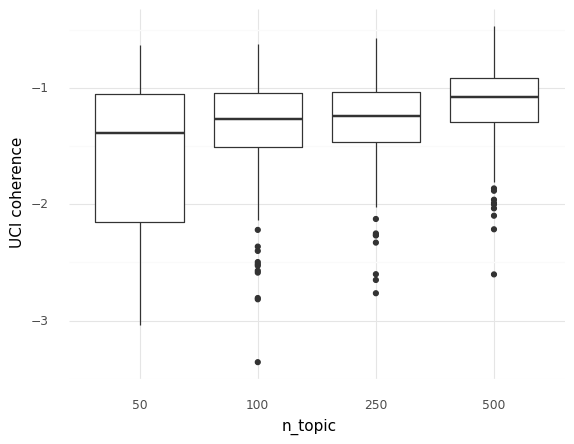

<ggplot: (8793919788129)>

In [17]:
(
    pn.ggplot(all_react_scores) + 
    pn.geom_boxplot(pn.aes(x='n_topic', y = "UCI")) + 
    pn.ylab("UCI coherence")+
    pn.theme_minimal()
)

In [26]:
def read_null_scores(file):
    with open(file, 'rb') as infl:
        reactome_scores = pickle.load(infl)
        return pd.DataFrame().assign(UCI = np.concatenate(reactome_scores).flatten())


In [27]:
k = read_scores("/data/vss2134/scTopic/results/null_matchscores/5k_50.pickle")

In [28]:
all_react_scores = pd.concat([
    read_scores("/data/vss2134/scTopic/results/vae_lda_normal_5k_50t_reactome_scores.pickle").assign(n_topic = "50"),
    read_null_scores("/data/vss2134/scTopic/results/null_matchscores/5k_50.pickle").assign(n_topic = "50, Random topics")
])

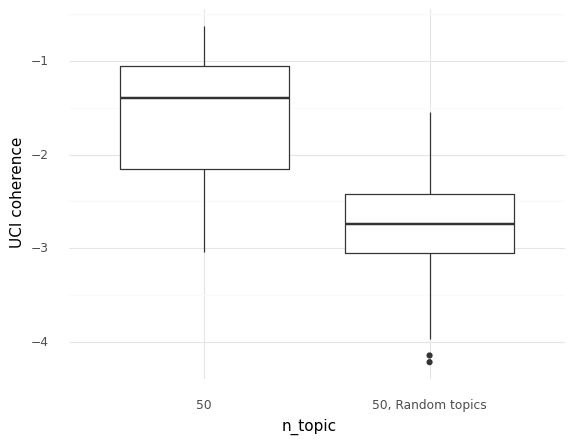

<ggplot: (8793919847548)>

In [29]:
(
    pn.ggplot(all_react_scores) + 
    pn.geom_boxplot(pn.aes(x='n_topic', y = "UCI")) + 
    pn.ylab("UCI coherence")+
    pn.theme_minimal()
)